# **Face Recognition Project**

### Загрузка данных

In [2]:
import requests
from urllib.parse import urlencode
import numpy as np

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/S8f03spLIA1wrw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

Разархивируем downloaded_file.zip

In [4]:
import zipfile

with zipfile.ZipFile('downloaded_file.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

Удалим ненужные файлы

In [5]:
import os

filename = 'downloaded_file.zip'

# Если файл существует, удаляем
if os.path.exists(filename):
    os.remove(filename)
    print(filename + " deleted")

downloaded_file.zip deleted


In [6]:
import shutil

filename = '/content/extracted_files/__MACOSX'

# Если файл существует, удаляем
if os.path.exists(filename):
    shutil.rmtree(filename)
    print(filename + " deleted")

/content/extracted_files/__MACOSX deleted


    Внутри:
            - celebA_imgs — папка с выровненными картинками;
            - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
            - celebA_train_split.txt — файл со сплитом на train/val/test.

In [7]:
import pandas as pd

In [28]:
from PIL import Image
import torch
from torch.utils.data import Dataset

from matplotlib import pyplot as plt

In [9]:
data_modes = ["train", "val", "test"]

In [11]:
df_anno = pd.read_csv("/content/extracted_files/celebA_train_500/celebA_anno.txt", sep='\s+', header=None)
df_split = pd.read_csv("/content/extracted_files/celebA_train_500/celebA_train_split.txt", sep='\s+', header=None)

In [10]:
ids = np.array(['000001.jpg', '000404.jpg', '101501.jpg'])

In [19]:
from torchvision import transforms

Создадим custom Dataset для подготовки данных

In [23]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, anno_file, split_file, mode):
        self.mode = mode
        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError
        self.img_dir = img_dir
        self.anno = pd.read_csv(anno_file, sep='\s+', header=None)
        self.train_split = pd.read_csv(split_file, sep='\s+', header=None)

        if mode == "train":
            self.img_ids = self.train_split[self.train_split[1] == 0][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        elif mode == "val":
            self.img_ids = self.train_split[self.train_split[1] == 1][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        else:
            self.img_ids = self.train_split[self.train_split[1] == 2][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        image = image.resize((224, 224))
        image = np.array(image)
        image = np.array(image / 255)
        image = transform(image)

        label = self.labels[img_id]
        return image, label

In [24]:
img_dir="/content/extracted_files/celebA_train_500/celebA_imgs"
anno_file="/content/extracted_files/celebA_train_500/celebA_anno.txt"
split_file="/content/extracted_files/celebA_train_500/celebA_train_split.txt"

tr_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="train"
)
val_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="val"
)
test_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="test"
)

Напишем функцию для вывода картинки

In [50]:
def imshow(inp, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.axis(False)
    plt_ax.imshow(inp)

И теперь посмотрим на лица в нашем датасете

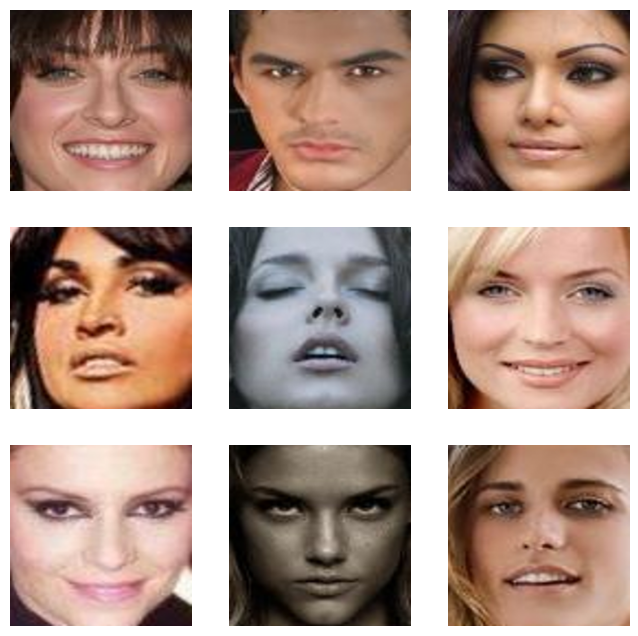

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax in axes.flatten():
    rand_person = int(np.random.uniform(0, val_dataset.__len__()))
    im_val, label = val_dataset[rand_person]
    imshow(im_val.data.cpu(), plt_ax=ax)

In [26]:
from torch.utils.data import DataLoader

In [27]:
tr_dataloader = DataLoader(tr_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)